# Notebook 2.6.3: The Freshman Plague

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [3]:
#@title
#@ Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap05.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap05 import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py
Downloaded ModSimPy_Functions/chap05.py


In [57]:
# Create a system
iS = 89; iI = 1; iR = 0    
tc = 3; tr = 4; t_end = 14*7

system = make_system(iS,iI,iR,tc,tr,t_end)

In [35]:
from numpy import exp

def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

def linear(x,m,b):
    return m*x + b

def expon(x,a,b,c):
    return (a * exp(b*x)) - c

def step(x):
    x = x/2500
    return 0.5*x.round(1)

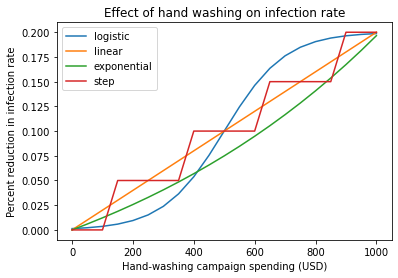

In [51]:
spending = linspace(0, 1000, 21)
log = logistic(spending, M=500, K=0.2, B=0.01)
lin = linear(spending,0.0002,0)
exp1 = expon(spending,0.12,0.00097,0.12)
step1 = step(spending)

#log,lin = compute_factor(spending) * 100

log = pd.Series(data=log,index=spending)
lin = pd.Series(data=lin,index=spending)
exp1 = pd.Series(data=exp1,index=spending)
step1 = pd.Series(data=step1,index=spending)

log.plot(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         label='logistic',legend=True);
lin.plot(legend=True, label='linear')
exp1.plot(legend=True, label='exponential')
step1.plot(legend=True, label='step');

Now we need to use `compute_factor` to change the `beta` for a particular simulation.

<br>

`add_hand_washing` takes a
systems object and a budget, and modifies `system['beta']` to model the
effect of hand washing:

In [53]:
def add_hand_washing(system, spending):
    factor = logistic(spending, M=500, K=0.2, B=0.01)
    #factor = linear(spending,0.0002,0)
    system['beta'] *= (1 - factor)

In [58]:
def sweep_hand_washing(system, spending_array):
    sweep = pd.Series([],dtype=object)

    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS']*N, system['iI']*N,system['iR']*N
    tc, tr, t_end= 1/system['beta'], 1/system['gamma'], system['t_end']
    
    for spending in spending_array:
        # make a system for this simulation
        system_local = make_system(iS,iI,iR,tc,tr,t_end)
        # change beta based on the amount spent on hand-washing
        add_hand_washing(system_local, spending)
        # run the simulation and save the metric: total people infected
        results = run_simulation(system_local, change_func)
        sweep[spending] = calc_total_infected(results, system_local)
        
    return sweep

In [59]:
from numpy import linspace

# Create the spending range through which we'll sweep
spending_array = linspace(0, 1200, 20)
# Calculate the percentage of total infected students for each spending value
infected_sweep2 = sweep_hand_washing(system,spending_array)

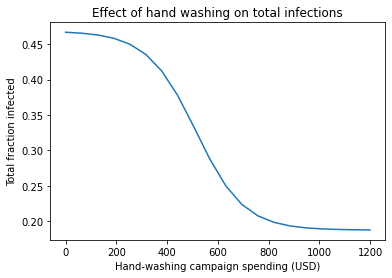

In [60]:
infected_sweep2.plot(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections');

## Optimization

Here's our budget

In [61]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)


In [62]:
def sweep_doses(system,dose_array):
    sweep = pd.Series([],dtype=object)
    
    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS']*N, system['iI']*N,system['iR']*N
    tc, tr, t_end= 1/system['beta'], 1/system['gamma'], system['t_end']

    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        # Adjust system according to preventive actions
        system_local = make_system(iS,iI,iR,tc,tr,t_end)
        add_immunization(system_local, fraction)
        add_hand_washing(system_local, spending)
        
        # Find results for each budget option
        results = run_simulation(system_local, change_func)
        sweep[doses] = calc_total_infected(results, system_local)

    return sweep

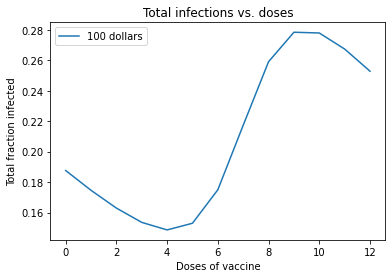

In [67]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)

infected_sweep3 = sweep_doses(system,dose_array)
infected_sweep3.plot(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',label='100 dollars',
         legend=True);

### Exploring the system

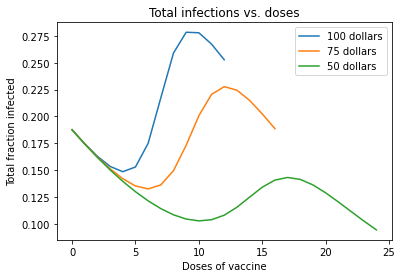

In [72]:
# Run and plot the results of sweep_doses here
num_students = 90
budget = 1200
price_per_dose = 75
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)
infected_sweep_75 = sweep_doses(system,dose_array)

price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)
infected_sweep_50 = sweep_doses(system,dose_array)

infected_sweep3.plot(label='100 dollars',legend=True)
infected_sweep_75.plot(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=True,label='75 dollars');
infected_sweep_50.plot(label='50 dollars',legend=True);

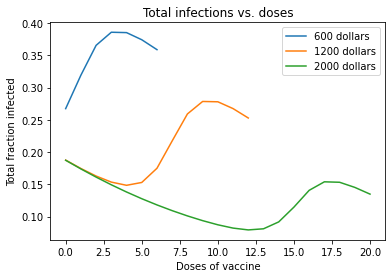

In [70]:
# Change the budget
num_students = 90
budget = 2000
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)

infected_sweep_2000 = sweep_doses(system,dose_array)

num_students = 90
budget = 600
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)
infected_sweep_600 = sweep_doses(system,dose_array)


infected_sweep_600.plot(label='600 dollars',legend=True)
infected_sweep3.plot(label='1200 dollars',legend=True)
infected_sweep_2000.plot(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=True,label='2000 dollars');